In [1]:
import torch
from torch import nn
from torch.utils import data
import torchvision
from utils import util
from matplotlib import pyplot as plt
from d2l import torch as d2l
from time import sleep
from IPython import display

## 加载数据

In [2]:
batch_size = 256
train_data_loader,test_data_loader = util.load_data_fashion_mnist(batch_size)

In [3]:
tmp_x,tmp_y = next(iter(train_data_loader))
print(tmp_x.shape,tmp_y.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


## 定义模型

模型的输入是28\*28的图片, 被展成784的向量, 所以输入是n\*784的矩阵

中间有一个隐藏层, 隐藏单元有256个(通常取2的幂, 方便计算机处理)

隐藏层的输入是n\*784, 输出是n\*256

$$
\begin{align}
  H^{(1)} &= \sigma(XW^{(1)}+b^{(1)}) \\
  X&\in R^{n*784} \\
  W^{(1)}&\in R^{784*256} \\
  b^{(1)}&\in R^{1*256} \\
  H^{(1)}&\in R^{n*256} \\
  \\
  
  \sigma(x) &=ReLU(x) \\
  			&=max(x,0) \\
\end{align}
$$

全连接层的输入是n\*256, 输出是n\*10

$$
  \begin{align}
  
  \hat Y &= H^{(1)}W^{(2)} + b^{(2)} \\
  H^{(1)}&\in R^{n*256} \\
  W^{(2)}&\in R^{256*10} \\
  b^{(2)}&\in R^{1*10}\\
  \hat Y &\in R^{n*10}
  
  \end{align}
$$

和softmax一样, 需要用softmax函数处理

考虑到softmax函数在计算时的上溢与下溢

所以将softmax与交叉熵损失函数结合起来


### 模型参数初始化

In [4]:
input_num = 784 # 输入神经元个数
hidden_num = 256 # 隐藏单元个数
output_num = 10 # 输出神经元个数

In [5]:
W1 = torch.normal(0,0.01,(input_num,hidden_num),requires_grad=True)
b1 = torch.zeros((hidden_num),requires_grad=True)
W2 = torch.normal(0,0.01,(hidden_num,output_num),requires_grad=True)
b2 = torch.zeros((output_num),requires_grad=True)


In [6]:
W1.shape,b1.shape

(torch.Size([784, 256]), torch.Size([256]))

In [7]:
W2.shape,b2.shape

(torch.Size([256, 10]), torch.Size([10]))

### ReLU

$$
\begin{align}
ReLU(x)=max(x,0)
\end{align}
$$

In [8]:
def ReLU(x):
    return torch.max(x,torch.zeros_like(x))

### 模型实现

In [9]:
def MLP(X:torch.tensor):
    H1 = ReLU(torch.matmul(X,W1) + b1)
    y_hat = torch.matmul(H1,W2) + b2
    return y_hat

## 损失函数

softmax函数与交叉熵损失函数一起实现

In [10]:
loss_function = nn.CrossEntropyLoss()

## 训练

### 累加记录器

In [11]:
class Accumulator:
    def __init__(self,n):
        """
            n表示要存放的元素类别
        """
        self.data = torch.zeros(n,dtype=torch.float32)
    
    def add(self,*args):
        """
            将args顺序放入
        """
        for i,arg in enumerate(args):
            self.data[i] += arg
    
    def reset(self):
        """
            将数值全部清空
        """
        self.data.zero_()
        
    def __getitem__(self,i):
        return float(self.data[i])

### 单次迭代

#### 精度计算

y_hat理论上是由概率构成, 但由于softmax计算的原因, 实际不是概率

但仍然可以根据y_hat中元素的大小来进行预测, 进而判断预测正确的数目

In [12]:
def accuracy(y_hat,y):
    """
        返回正确的预测数, 样本总数
    """
    return int((y_hat.max(dim=1).indices == y).sum()), y.shape[0]

#### 测试数据集损失与精度

计算测试数据集的损失与精度也比较繁琐, 所以封装一下

In [13]:
def get_test_data_loss_acc(net,loss_function,test_data):
    # 记录测试loss，正确的预测数，样本总数
    evaluator = Accumulator(3)
    for x,y in test_data:
        y_hat = net(x.reshape((-1,input_num)))
        loss = loss_function(y_hat,y)
        right,total = accuracy(y_hat,y)
        
        evaluator.add(loss,right,total)
    return evaluator[0] / evaluator[2], evaluator[1] / evaluator[2]
    

#### 单次迭代

In [14]:
def train_epoch(net,loss_function,updater,train_data):
    """
        返回训练的平均损失, 训练精度
    """
    # 存放loss，预测正确数，总的预测数
    evaluator = Accumulator(3) 
    for x,y in train_data:
        y_hat = net(x.reshape((-1,input_num)))
        loss = loss_function(y_hat,y)
        
        if isinstance(updater,torch.optim.Optimizer):
            # 内置优化器
            updater.zero_grad()
            loss.sum().backward()
            updater.step()
        else:
            loss.sum().backward()
            updater(x.shape[0])

        # 根据y_hat,y更新evaluator
        right,total = accuracy(y_hat,y)
        evaluator.add(loss.sum(),right,total)
    return evaluator[0] / evaluator[2], evaluator[1] / evaluator[2]
    

#### 动态绘图效果

In [15]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        
        d2l.use_svg_display()
        
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        
        # 纬度扩展
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        
        if not hasattr(x, "__len__"):
            x = [x] * n
        
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
                
        self.axes[0].cla()
        
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [16]:
def TEST_Aminator():
    animator = Animator(xlabel="x",ylabel="f(x)",legend=["$i^2$","$i^3$","$e^i$"])
    for i in range(10):
        a,b,c = i**2,i**3,torch.e**i
        animator.add(i,(a,b,c))
        sleep(1)  

##### 测试

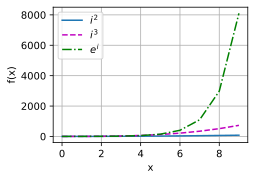

In [17]:
TEST_Aminator()

#### 迭代

In [18]:
def train(net,loss_fucntion,updater,epochs,train_data,test_data):
    print("epoch:\tloss: train\ttest, acc: train\ttest")
    animator = Animator(xlabel="epoch",ylabel="loss/acc",legend=["train_loss","test_loss","train_acc","test_acc"])
    for epoch in range(epochs):
        train_loss,train_acc = train_epoch(net,loss_fucntion,updater,train_data)
        # 在测试数据集上计算
        test_loss,test_acc = get_test_data_loss_acc(net,loss_function,test_data)
        animator.add(epoch+1,[train_loss,test_loss,train_acc,test_acc])
        print(f"{epoch}\t{train_loss}\t{test_loss}\t{train_acc}\t{test_acc}")
        

### 测试

In [19]:
params = [W1,b1,W2,b2]
lr = 0.1
updater = torch.optim.SGD(params,lr)
epochs = 10

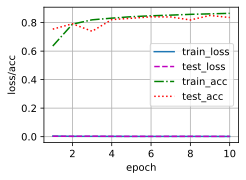

In [20]:
train(MLP,loss_function,updater,epochs,train_data_loader,test_data_loader)

## 预测

从验证集(这里就用测试集)中选取x,y 

利用模型计算得到y_hat, 然后再选取对应的标签

### 将标签（int）转成标签（str）

In [27]:
def labels_int_to_str(labels_int):
    labels_str = ['t-shirt', 'trouser', 'pullover', 'dress',
                   'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [ labels_str[label_int] for label_int in labels_int]

### 绘图

In [49]:
def plot_test_result(x,real,predict,row,column):
    fig,axes = plt.subplots(nrows=row,ncols=column)

    # return 
    for i in range(row):
        for j in range(column):
            index = i*column+j
            axes[i][j].get_xaxis().set_visible(False)
            axes[i][j].get_yaxis().set_visible(False)
            axes[i][j].set_title(f"{real[index]}\n{predict[index]}")
            axes[i][j].imshow(x[index])

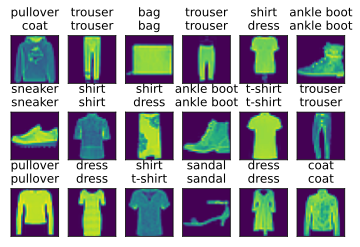

In [51]:
row = 3
column = 6
for x,y in test_data_loader:
    x = x[:row*column,]
    y_hat = MLP(x.reshape(-1,input_num))
    pred_labels_int = y_hat.max(dim=1).indices
    pred_labels_str = labels_int_to_str(pred_labels_int)
    labels_str = labels_int_to_str(y)
    plot_test_result(x.reshape(row*column,28,28),labels_str,pred_labels_str,row,column)
    
    break